# Navigating Data Cubes with NDData and Dictionaries

by Jacqueline Goldstein and Aaron Lopez

*Keywords: Dictionary, Glob, Data slicing, LaTeX, Animation, NDdata, EZ-web, profiles, timeseries*

## Learning Objectives

- Create EZ-Web model
- Explore EZ-Web model structures
- Import data from text files into a 3d numpy array
- Create 3d datasets using NDdata
- Create dictionary
- Assign metadata to NDdata cube
- Access/manipulate across different dimensions using dict keys
- Plot data
- Make a movie using maptlotlib.animate

## Submit an EZ-Web calculation

EZ-Web is a web-based interface to the stellar evolution code Evolve ZAMZ, developed by Bill Paxton. The interface itself was written by UW Madison's Rich Townsend, and it allows a user to perform stellar evolution calculations on a remote server and receive the output via email.

## Import relevant libraries

In [1]:
from astropy.nddata import NDData
import glob
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML
%matplotlib inline

## Create numpy array from files

In [2]:
num_files = 0   # The number of structure files, which corresponds to number timesteps.
num_columns = 0 # The number of columns, which corresponds to number of variables.
num_rows = 0    # The number of rows, which corresponds to number of zones along the radius
                # where zone = 0 is at the surface of the star.
filenames = []  # List of filenames

First, record the dimensions of each zone-time slice. We will take this from the number of columns and the number of zones in the first profile. We must make sure that our path to the text files is correct!

In [3]:
for file in glob.glob('ezweb-1-Msun/structure*txt'):
    if num_files is 0:
        profile = np.genfromtxt(file)
        num_rows = profile.shape[0] 
        num_columns = profile.shape[1]
    num_files += 1
    filenames.append(file)

Next, we create an empty 3D array of size num_rows\*num_columns\*num_profiles. This corresponds to the cube size zones\*timesteps\*variables.

In [4]:
star_data = np.empty((num_rows,num_columns,num_files))

We iterate over each profile and populate the cube. The zip() function combines elements from two lists into a single list of tuples.

In [5]:
for num_file, filename in zip(range(num_files), filenames):
    star_data[:,:,num_file] = np.genfromtxt(filename)

## Create dictionary from list of variables

Now, we create a dictionary using the list of variable names as keys. This list is available on EZ-web. The values for each key will correspond to the variable's column index. To create the dictionary, we may use list comprehension to associate each key with its index.

In [6]:
variables = ['m', 'r', 'F', 'P', 'rho', 'T', 'u', 's', 'c_P', 'gamma_ad', 'nabla_ad',\
             'mu', 'n_e', 'P_e', 'P_rad', 'nabla_rad', 'nabla', 'v_c', 'kappa',\
             'q_nuc', 'q_PP', 'q_CNO', 'q_3a', 'q_nunuc', 'q_nu', 'q_grav', 'X',\
             'X_mol', 'X_+', 'Y', 'Y_+', 'Y_++', 'X_C', 'X_N', 'X_O', 'Psi']

variable_dict = dict([(v[1],v[0]) for v in enumerate(variables)])

*Editor's note: maybe we can add units to this dictionary? If we make the value not just the index, but tuples of (index,astropy_units)*

## Create NDData from numpy array and dictionary

We can associate the dictionary of variables with the profile cube by combining them into an astropy NDData object.

In [7]:
star_nddata = NDData(data=star_data, meta=variable_dict)

## Extract and plot data

Now that we have our 3D NDdata structure with meta dictionary keys,
lets extract and plot some zone-time slices for temperature and mass.

In [8]:
# NDData data is accessed returned via NDData.data
# NDData meta data is accessed via NDData.meta

def z_t_slice(var):
    """Return a zone-profile slice of the variable 'var'."""
    
    return star_nddata.data[:,star_nddata.meta[var],:]   

In [9]:
temperature = z_t_slice('T')
mass = z_t_slice('m')

Let's plot the temperature (T) vs fractional mass (m/M) at the first timestep.

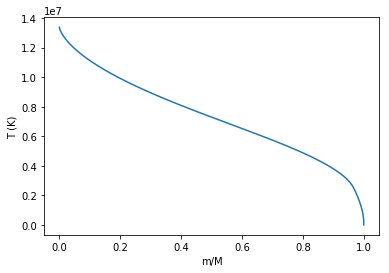

In [10]:
fig, ax = plt.subplots()
ax.set_xlabel('m/M')
ax.set_ylabel('T (K)')
_ = ax.plot(mass[:,0]/mass[0,0],temperature[:,0])

Now let's see how this (T) vs (m/M) plot evolves over time.

In [11]:
fig, ax = plt.subplots()

ax.set_ylim((np.min(temperature[:,:]), np.max(temperature[:,:])))
ax.set_xlabel('m/M')
ax.set_ylabel('T')

# Create the initial line

line, = ax.plot(mass[:,0]/mass[0,0], temperature[:,0])

# Update the line plot 

def animate(t):
    ax.set_title(t)
    line.set_data(mass[:,t]/mass[0,t], temperature[:,t])
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(1, num_files, 10))

# Save the animation as a gif and close the figure. 

ani.save("animate.gif", writer='imagemagick')

plt.close()

# Animate the figure in the notebook

HTML(ani.to_html5_video())